In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
import torch.nn as nn
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)

class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)

In [4]:
class UNet_3Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

In [5]:
model = UNet_3Plus()

In [6]:
class UNet_3Plus_DeepSup_CGM(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus_DeepSup_CGM, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # -------------Bilinear Upsampling--------------
        self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear')###
        self.upscore5 = nn.Upsample(scale_factor=16,mode='bilinear')
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear')

        # DeepSup
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv2 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv3 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv4 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv5 = nn.Conv2d(filters[4], n_classes, 3, padding=1)

        self.cls = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Conv2d(filters[4], 2, 1),
                    nn.AdaptiveMaxPool2d(1),
                    nn.Sigmoid())

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def dotProduct(self,seg,cls):
        B, N, H, W = seg.size()
        seg = seg.view(B, N, H * W)
        final = torch.einsum("ijk,ij->ijk", [seg, cls])
        final = final.view(B, N, H, W)
        return final

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        # -------------Classification-------------
        cls_branch = self.cls(hd5).squeeze(3).squeeze(2)  # (B,N,1,1)->(B,N)
        cls_branch_max = cls_branch.argmax(dim=1)
        cls_branch_max = cls_branch_max[:, np.newaxis].float()

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d5 = self.outconv5(hd5)
        d5 = self.upscore5(d5) # 16->256

        d4 = self.outconv4(hd4)
        d4 = self.upscore4(d4) # 32->256

        d3 = self.outconv3(hd3)
        d3 = self.upscore3(d3) # 64->256

        d2 = self.outconv2(hd2)
        d2 = self.upscore2(d2) # 128->256

        d1 = self.outconv1(hd1) # 256

        d1 = self.dotProduct(d1, cls_branch_max)
        d2 = self.dotProduct(d2, cls_branch_max)
        d3 = self.dotProduct(d3, cls_branch_max)
        d4 = self.dotProduct(d4, cls_branch_max)
        d5 = self.dotProduct(d5, cls_branch_max)

        return F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5)

In [7]:
#Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import numpy as np
print("numpy version:",np.__version__)

import cv2
print("cv2 version:",cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

Python version: 3.9.18
numpy version: 1.24.3
cv2 version: 4.8.1
matplotlib version: 3.8.0
pandas version: 2.0.3


In [8]:
#Function to change the path format
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [9]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('IC-SHM_2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name',
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]


In [10]:
print(len(train_dmg))

4381


In [11]:
train_dmg

,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,43.375470
3,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,43.242723
5,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,20.921244
7,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,46.639972
11,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,53.623157
...,...,...,...,...,...
13941,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,51.725212
13942,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,53.422408
13945,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,41.561651
13949,IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/la...,IC-SHM_2021\Tokaido_dataset\synthetic/train/de...,36.669088


image file name                         IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...
component label file name               IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
damage label file name                  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
depth image file name                   IC-SHM_2021\Tokaido_dataset\synthetic/train/de...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


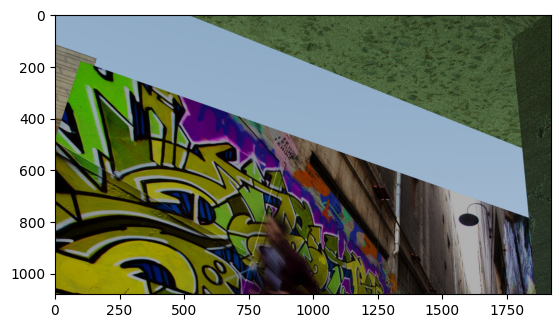

In [12]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)

image file name                         IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...
component label file name               IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
damage label file name                  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
depth image file name                   IC-SHM_2021\Tokaido_dataset\synthetic/train/de...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


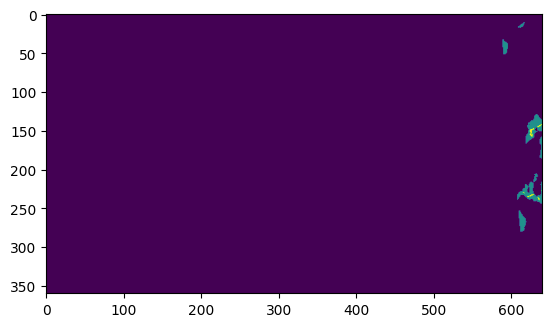

In [13]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][2])   #[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [14]:
#Run for training on the damage images
train1 = train_dmg[:4000]
val1 = train_dmg[4000:]

In [15]:
len(val1)

381

image file name           IC-SHM_2021\Tokaido_dataset\images_puretex/im8...
damage label file name    IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
Name: 0, dtype: object
(360, 640)
<class 'numpy.ndarray'>


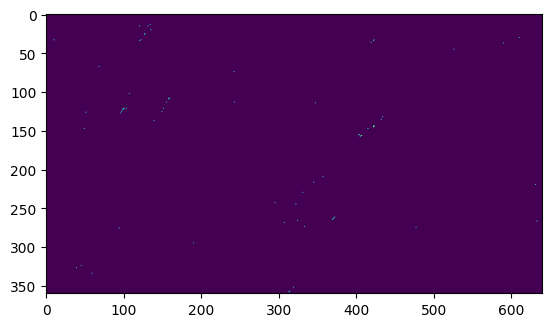

In [16]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('IC-SHM_2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'damage label file name']

ftrain = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))

train_tex = ftrain
#Printing the training image
print(ftrain.iloc[0])
image = mpimg.imread(ftrain.iloc[0][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [17]:
print(len(train_tex))

2700


In [18]:
train_tex

,image file name,damage label file name
0,IC-SHM_2021\Tokaido_dataset\images_puretex/im8...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
1,IC-SHM_2021\Tokaido_dataset\images_puretex/im4...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
2,IC-SHM_2021\Tokaido_dataset\images_puretex/im7...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
3,IC-SHM_2021\Tokaido_dataset\images_puretex/im2...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
4,IC-SHM_2021\Tokaido_dataset\images_puretex/im9...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
...,...,...
2695,IC-SHM_2021\Tokaido_dataset\images_puretex/im7...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
2696,IC-SHM_2021\Tokaido_dataset\images_puretex/im8...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
2697,IC-SHM_2021\Tokaido_dataset\images_puretex/im1...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
2698,IC-SHM_2021\Tokaido_dataset\images_puretex/im2...,IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...


In [19]:
# Append the first 2300 rows from 'train_tex' to 'train1'
train1 = pd.concat([train1, train_tex[:2300]])

# Append the remaining rows from 'train_tex' to 'val1'
val1 = pd.concat([val1, train_tex[2300:]])

In [20]:
print('Train Size:' , len(train1), ' Val Size:' , len(val1))

Train Size: 6300  Val Size: 781


In [21]:
def show_img(image):
  #image = np.squeeze(image, axis = -1)
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class Dataset(Dataset):
    def __init__(self, img_path, label_path, transform=None):
        self.img_path = img_path
        self.label_path = label_path
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):

        # Load image and label
        image = Image.open(self.img_path[idx]).convert('RGB')
        mask = Image.open(self.label_path[idx])
        #mask = torch.from_numpy(get_label(self.label_path[idx]))

        # Apply transformations and augmentations if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations and augmentations
transform = transforms.Compose([
    transforms.Resize((256, 448)),
    transforms.ToTensor(),
])

In [23]:
images = train1['image file name'].to_numpy()
masks = train1['damage label file name'].to_numpy()
train_dataset = Dataset(images, masks, transform)


images_val = val1['image file name'].to_numpy()
masks_val = val1['damage label file name'].to_numpy()
val_dataset = Dataset(images_val, masks_val, transform)

In [24]:
len(train_dataset)

6300

torch.Size([3, 256, 448])
torch.Size([1, 256, 448])


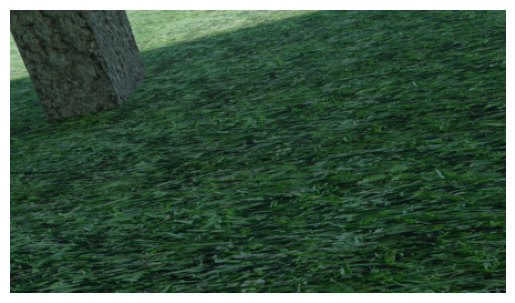

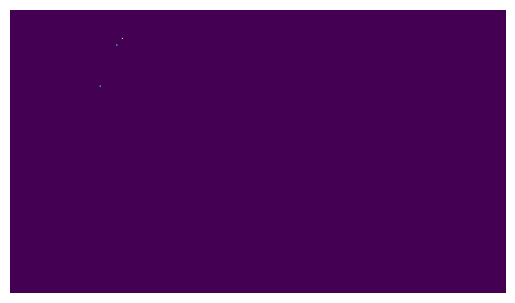

In [25]:
for img,mask in train_dataset:
  show_img(img.permute(1,2,0))
  print(img.shape)
  show_img(mask.permute(1,2,0))
  print(mask.shape)
  break

In [26]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [27]:
for batch in train_loader:
  print(batch[0].shape)
  print(batch[1].shape)
  break

torch.Size([1, 3, 256, 448])
torch.Size([1, 1, 256, 448])


In [28]:
# import torch

# def dice_loss(logits, targets):
#     smooth = 1.0  # Smoothing factor to avoid division by zero
#     intersection = torch.sum(logits * targets)
#     union = torch.sum(logits) + torch.sum(targets)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice  # We return 1 - Dice to minimize it as a loss

# def intersection_over_union(outputs, targets):
#     smooth = 1e-6  # Smoothing factor to avoid division by zero
#     intersection = torch.sum(outputs * targets)
#     union = torch.sum(outputs) + torch.sum(targets) - intersection
#     iou = (intersection + smooth) / (union + smooth)
#     return iou

# def precision(outputs, targets):
#     true_positives = torch.sum(outputs * targets)
#     false_positives = torch.sum(outputs * (1 - targets))
#     precision = true_positives / (true_positives + false_positives)
#     return precision

# def recall(outputs, targets):
#     true_positives = torch.sum(outputs * targets)
#     false_negatives = torch.sum((1 - outputs) * targets)
#     recall = true_positives / (true_positives + false_negatives)
#     return recall


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define your CustomDataset, UNet_3Plus, and other necessary components

# Define hyperparameters
num_epochs = 10
learning_rate = 0.00001

# Initialize your UNet_3Plus model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_3Plus(in_channels=3, n_classes=1).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00000001)

# Initialize empty lists to store metrics and losses
train_losses = []
val_losses = []



In [39]:
# # Define the path to the saved model checkpoint
# model_checkpoint_path = '/content/unet_3plus_epoch_2.pth'

# # Load the saved model state dictionary
# model.load_state_dict(torch.load(model_checkpoint_path,map_location=torch.device('cpu')))


# start_epoch = 2

Epoch [1/10] (Train):   0%|          | 0/6300 [00:00<?, ?it/s]

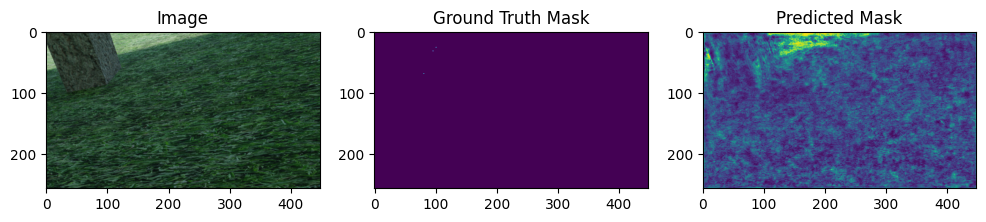

Epoch [1/10] (Train):  16%|█▌        | 1000/6300 [14:14<45:29,  1.94it/s] 

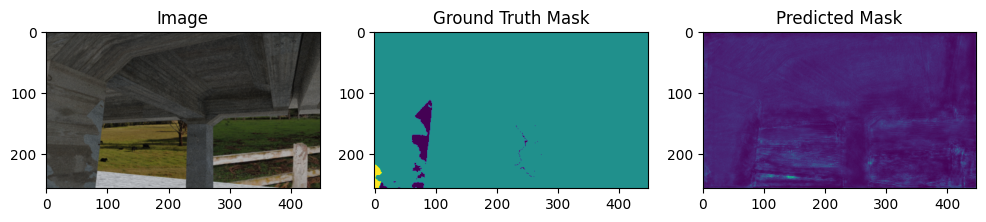

Epoch [1/10] (Train):  32%|███▏      | 2000/6300 [27:26<1:00:47,  1.18it/s]

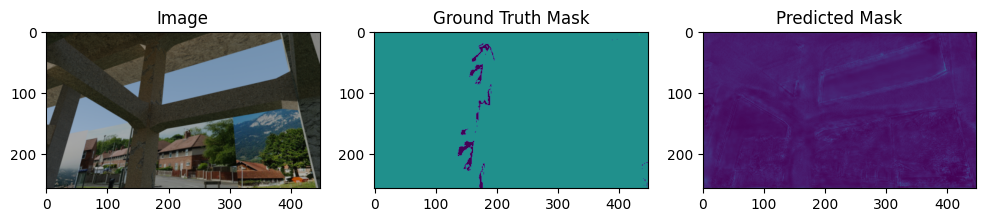

Epoch [1/10] (Train):  48%|████▊     | 3000/6300 [41:46<48:04,  1.14it/s]  

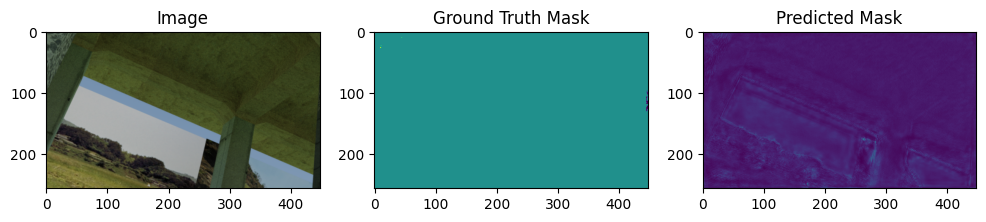

Epoch [1/10] (Train):  63%|██████▎   | 4000/6300 [54:42<33:34,  1.14it/s]

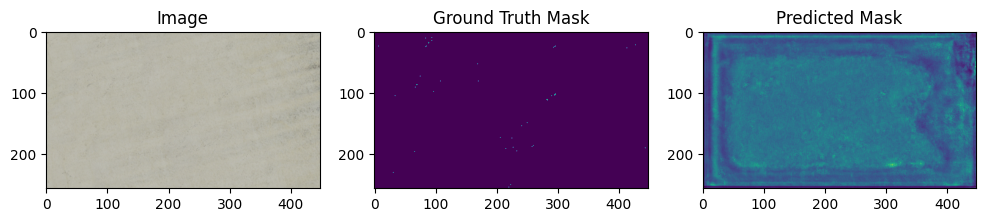

Epoch [1/10] (Train):  79%|███████▉  | 5000/6300 [1:09:20<19:04,  1.14it/s]

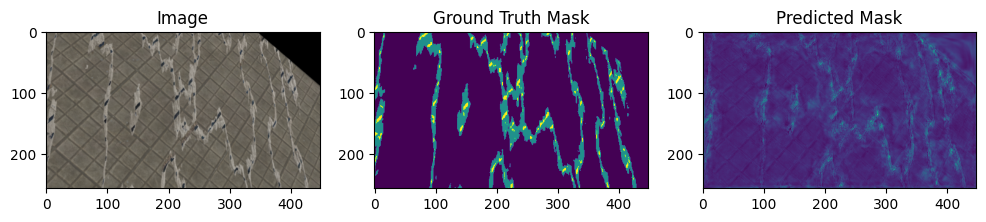

Epoch [1/10] (Train):  95%|█████████▌| 6000/6300 [1:22:42<04:27,  1.12it/s]

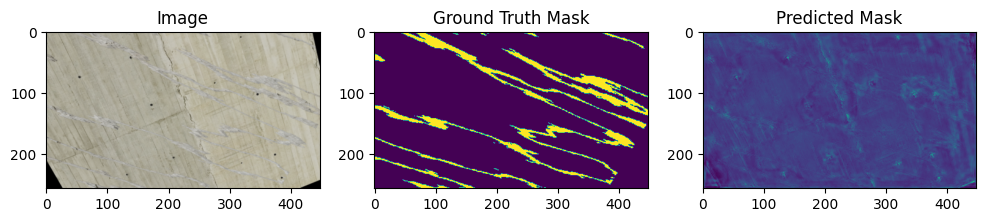

Epoch [1/10] (Train): 100%|██████████| 6300/6300 [1:27:03<00:00,  1.21it/s]


Epoch [1/10] Train Loss: 0.0319


Epoch [1/10] (Val):   0%|          | 0/781 [00:00<?, ?it/s]

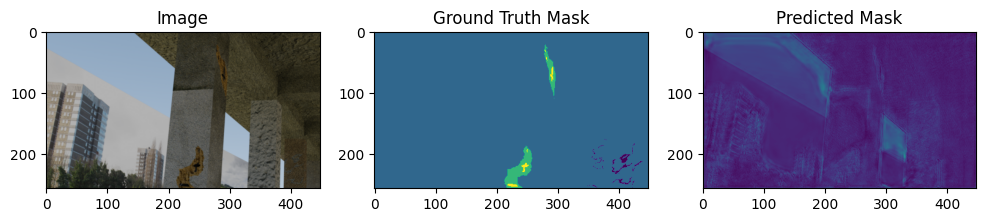

Epoch [1/10] (Val):  26%|██▌       | 200/781 [00:53<02:27,  3.95it/s]

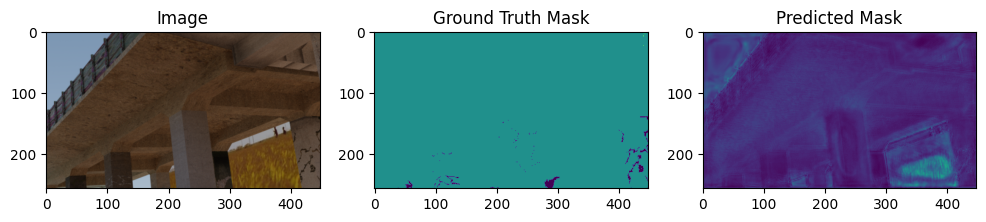

Epoch [1/10] (Val):  51%|█████     | 400/781 [01:46<01:55,  3.29it/s]

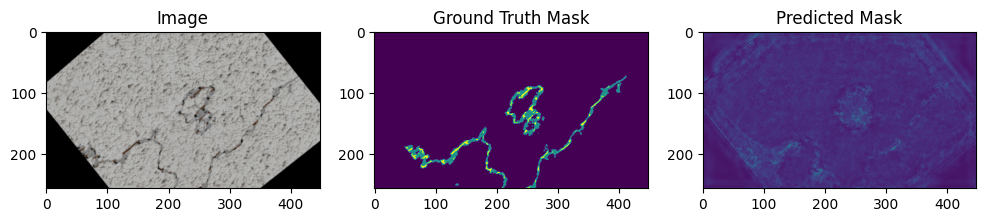

Epoch [1/10] (Val):  77%|███████▋  | 600/781 [02:44<00:53,  3.38it/s]

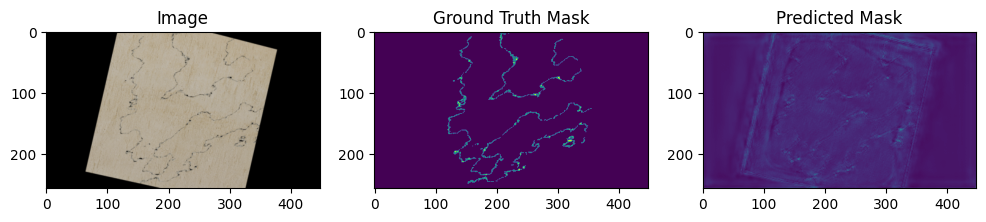

Epoch [1/10] (Val): 100%|██████████| 781/781 [03:36<00:00,  3.61it/s]


Epoch [1/10] Val Loss: 0.0268


Epoch [2/10] (Train):   0%|          | 0/6300 [00:00<?, ?it/s]

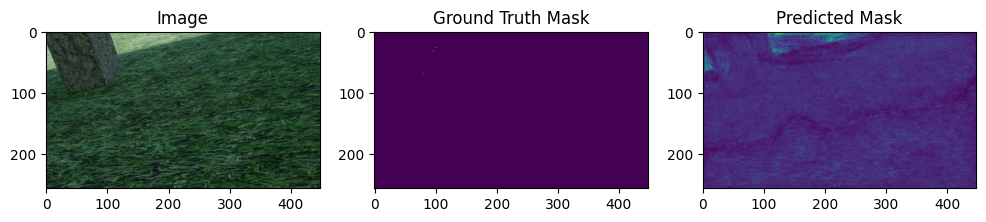

Epoch [2/10] (Train):   1%|          | 76/6300 [01:09<1:37:32,  1.06it/s]

In [41]:
# Training and validation loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] (Train)")):
        batch_images, batch_masks = batch
        batch_images = batch_images.to(device)
        batch_masks = batch_masks.to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Visualize images, masks, and predicted masks
        if (batch_idx%1000) == 0:
            for i in range(1):
                image = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                mask = batch_masks[i].cpu().numpy().squeeze()
                predicted_mask = outputs[i].cpu().detach().numpy().squeeze()

                plt.figure(figsize=(12, 4))
                plt.subplot(131)
                plt.imshow(image)
                plt.title("Image")

                plt.subplot(132)
                plt.imshow(mask)
                plt.title("Ground Truth Mask")

                plt.subplot(133)
                plt.imshow(predicted_mask)
                plt.title("Predicted Mask")

                plt.show()

    average_train_loss = train_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {average_train_loss:.4f}")


    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] (Val)")):
            batch_images, batch_masks = batch
            batch_images = batch_images.to(device)
            batch_masks = batch_masks.to(device)

            outputs = model(batch_images)
            loss = criterion(outputs, batch_masks)

            val_loss += loss.item()
            # Visualize images, masks, and predicted masks
            if (batch_idx%200) == 0:
                for i in range(1):
                    image = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                    mask = batch_masks[i].cpu().numpy().squeeze()
                    predicted_mask = outputs[i].cpu().numpy().squeeze()

                    plt.figure(figsize=(12, 4))
                    plt.subplot(131)
                    plt.imshow(image)
                    plt.title("Image")

                    plt.subplot(132)
                    plt.imshow(mask)
                    plt.title("Ground Truth Mask")

                    plt.subplot(133)
                    plt.imshow(predicted_mask)
                    plt.title("Predicted Mask")

                    plt.show()

    average_val_loss = val_loss / len(val_loader)

     # Append losses and metrics to lists
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)


    print(f"Epoch [{epoch + 1}/{num_epochs}] Val Loss: {average_val_loss:.4f}")


    # Save the model after each epoch
    model_save_path = f"unet_3plus_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_save_path)

# Save your trained model if needed
torch.save(model.state_dict(), "unet_3plus.pth")


In [ ]:
# # Plot the loss and metric curves
# plt.figure(figsize=(12, 8))

# # Plot Loss Curves
# plt.subplot(2, 2, 1)
# plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
# plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training and Validation Loss Curves")
# plt.grid(True)

# # Plot IoU Curves
# plt.subplot(2, 2, 2)
# plt.plot(range(1, num_epochs + 1), train_iou_scores, label="Train IoU")
# plt.plot(range(1, num_epochs + 1), val_iou_scores, label="Validation IoU")
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend()
# plt.title("Training and Validation IoU Curves")
# plt.grid(True)

# # Plot Precision Curves
# plt.subplot(2, 2, 3)
# plt.plot(range(1, num_epochs + 1), train_precision_scores, label="Train Precision")
# plt.plot(range(1, num_epochs + 1), val_precision_scores, label="Validation Precision")
# plt.xlabel("Epoch")
# plt.ylabel("Precision")
# plt.legend()
# plt.title("Training and Validation Precision Curves")
# plt.grid(True)

# # Plot Recall Curves
# plt.subplot(2, 2, 4)
# plt.plot(range(1, num_epochs + 1), train_recall_scores, label="Train Recall")
# plt.plot(range(1, num_epochs + 1), val_recall_scores, label="Validation Recall")
# plt.xlabel("Epoch")
# plt.ylabel("Recall")
# plt.legend()
# plt.title("Training and Validation Recall Curves")
# plt.grid(True)

# # Adjust layout and show the plots
# plt.tight_layout()
# plt.show()